In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
import unittest
from pypvcell.solarcell import SQCell, MJCell

from pypvcircuit.spice_module_solver import SingleModuleStringSolver, MultiStringModuleSolver
from pypvcell.illumination import load_astm
import pypvcell.fom as fom

import matplotlib.pyplot as plt
import numpy as np

from pypvcircuit.parse_spice_input import NodeReducer

In [4]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

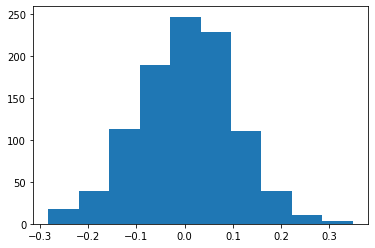

In [5]:
plt.hist(s)
plt.show()

In [6]:
gaas_1j = SQCell(1.42, 300, 1)
ingap_1j = SQCell(1.87, 300, 1)
ge_1j = SQCell(0.7, 300, 1)

mj_cell = MJCell([ingap_1j, gaas_1j, ge_1j])

nd = NodeReducer()

stdev = 0.1

cell_num_array = np.array([2, 3, 4, 5, 6, 7, 8, 9])
trial = 100
pm_store = np.empty((cell_num_array.shape[0], trial))
isc_store = np.empty((cell_num_array.shape[0], trial))

for std_index, cell_num in enumerate(cell_num_array):

    for tt in range(trial):
        sm = MultiStringModuleSolver(solarcell=mj_cell, illumination=500,
                                     v_start=0, v_end=3.5 * cell_num, v_steps=0.1, l_r=1e-3, l_c=1e-3,
                                     cell_number=cell_num, string_number=cell_num, isc_stdev=stdev,
                                     spice_preprocessor=None)

        # print(sm._generate_network())

        sm._solve_circuit()
        calc_isc=fom.isc(sm.V, sm.I)/cell_num
        max_p = fom.max_power(sm.V, sm.I) / (cell_num ** 2)

        pm_store[std_index, tt] = max_p
        isc_store[std_index,tt] = calc_isc

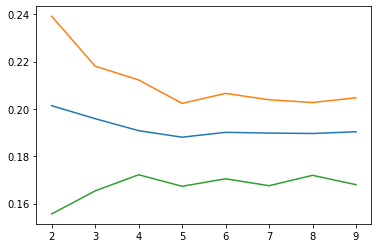

In [9]:
plt.plot(cell_num_array, pm_store.mean(axis=1))
plt.plot(cell_num_array, pm_store.max(axis=1))
plt.plot(cell_num_array, pm_store.min(axis=1))
plt.show()

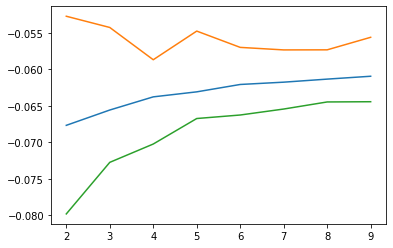

In [10]:
plt.plot(cell_num_array, isc_store.mean(axis=1))
plt.plot(cell_num_array, isc_store.max(axis=1))
plt.plot(cell_num_array, isc_store.min(axis=1))
plt.show()